In [26]:
!pip install gensim --upgrade
!pip install keras --upgrade
!pip install pandas --upgrade

In [5]:
import re
import pickle
import numpy as np
import pandas as pd

import seaborn as sns
from wordcloud import WordCloud
import matplotlib.pyplot as plt

from nltk.stem import WordNetLemmatizer


from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.manifold import TSNE
from sklearn.feature_extraction.text import TfidfVectorizer

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import GlobalMaxPooling1D
from keras.layers import Activation, Dense, Dropout, Embedding, Flatten, Conv1D, MaxPooling1D, LSTM
from keras import utils
from keras.callbacks import ReduceLROnPlateau, EarlyStopping
from keras.models import load_model

import gensim

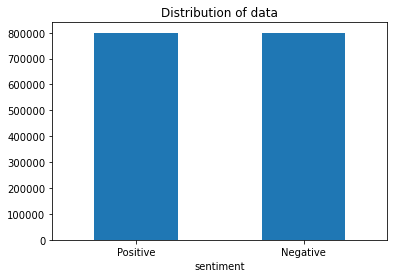

In [12]:
columns  = ["sentiment", "ids", "date", "flag", "user", "text"]

data = pd.read_csv(r"F:\College\Thesis\Thesis code\LargeSentimentTwitterData.csv", 
                   encoding = "ISO-8859-1", names = columns)

data = data[['sentiment','text']]
data['sentiment'] = data['sentiment'].replace(4,1)

ax = data.groupby('sentiment').count().plot(kind='bar', title='Distribution of data',
                                               legend=False)
ax.set_xticklabels(['Positive','Negative'], rotation=0)


tweet = list(data['text'])
sentiment = np.array(list(data['sentiment']))

In [13]:
def dataProcess(textdata):
    processedText = []
    
    wordLemm = WordNetLemmatizer()
  
    nonAlpha = "[^a-zA-Z0-9]"
    
    for tweet in textdata:
        tweet = tweet.lower()   
        
        tweet = re.sub(nonAlpha, " ", tweet)

        tweetwords = ''
        for word in tweet.split():
            if len(word)>1:
                word = wordLemm.lemmatize(word)
                tweetwords += (word+' ')
            
        processedText.append(tweetwords)
        
    return processedText

In [14]:
import time
t = time.time()
processedtext = dataProcess(tweet)
print(f'Text Preprocessing complete.')
print(f'Time Taken: {round(time.time()-t)} seconds')

Text Preprocessing complete.
Time Taken: 84 seconds


In [15]:
xTrain, xTest, yTrain, yTest = train_test_split(processedtext, sentiment, test_size = 0.5, random_state = 0)

print(f'Data Split done.')

Data Split done.


In [16]:
tokenizer = Tokenizer(oov_token="<OOV>")
tokenizer.fit_on_texts(xTrain)

X_train = tokenizer.texts_to_sequences(xTrain)
X_test = tokenizer.texts_to_sequences(xTest)

print(f'Token done.')

Token done.


In [17]:
vocabSize = len(tokenizer.word_index) + 1

maxlen = 300

X_train = pad_sequences(X_train, padding='post', maxlen=maxlen)
X_test = pad_sequences(X_test, padding='post', maxlen=maxlen)

print(f'Done.')

Done.


In [14]:
from numpy import array
from numpy import asarray
from numpy import zeros

embeddings_dictionary = dict()
glove_file = open(r'C:\Users\Admin\Downloads\glove.6B.100d.txt', encoding="utf8")

for line in glove_file:
    records = line.split()
    word = records[0]
    vector_dimensions = asarray(records[1:], dtype='float32')
    embeddings_dictionary [word] = vector_dimensions
glove_file.close()

embedding_matrix = zeros((vocabSize, 100))
for word, index in tokenizer.word_index.items():
    embedding_vector = embeddings_dictionary.get(word)
    if embedding_vector is not None:
        embedding_matrix[index] = embedding_vector
        

print(f'Done.')

Done.


In [72]:
model = Sequential()
embedding_layer = Embedding(vocabSize, 100, weights=[embedding_matrix], input_length=maxlen , trainable=False)
model.add(embedding_layer)

model.add(Flatten())
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])

print(model.summary())

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_10 (Embedding)     (None, 300, 100)          40260000  
_________________________________________________________________
flatten_7 (Flatten)          (None, 30000)             0         
_________________________________________________________________
dense_8 (Dense)              (None, 1)                 30001     
Total params: 40,290,001
Trainable params: 30,001
Non-trainable params: 40,260,000
_________________________________________________________________
None


In [76]:
history = model.fit(X_train, yTrain, batch_size=512, epochs=15, verbose=1, validation_split=0.1)

score = model.evaluate(X_test, yTest, verbose=1)

print("Test Score:", score[0])
print("Test Accuracy:", score[1])

Epoch 1/15
1407/1407 [==============================] - 37s 26ms/step - loss: 0.5694 - acc: 0.7109 - val_loss: 0.5709 - val_acc: 0.7094
Epoch 2/15
1407/1407 [==============================] - 38s 27ms/step - loss: 0.5694 - acc: 0.7110 - val_loss: 0.5718 - val_acc: 0.7099
Epoch 3/15
1407/1407 [==============================] - 37s 27ms/step - loss: 0.5693 - acc: 0.7109 - val_loss: 0.5720 - val_acc: 0.7110
Epoch 4/15
1407/1407 [==============================] - 38s 27ms/step - loss: 0.5696 - acc: 0.7107 - val_loss: 0.5702 - val_acc: 0.7100
Epoch 5/15
1407/1407 [==============================] - 38s 27ms/step - loss: 0.5693 - acc: 0.7110 - val_loss: 0.5710 - val_acc: 0.7098
Epoch 6/15
1407/1407 [==============================] - 37s 27ms/step - loss: 0.5693 - acc: 0.7104 - val_loss: 0.5729 - val_acc: 0.7099
Epoch 7/15
1407/1407 [==============================] - 38s 27ms/step - loss: 0.5692 - acc: 0.7109 - val_loss: 0.5716 - val_acc: 0.7078
Epoch 8/15
1407/1407 [==========================

In [15]:
model2 = Sequential()

embedding_layer = Embedding(vocabSize, 100, weights=[embedding_matrix], input_length=maxlen , trainable=False)
model2.add(embedding_layer)

model2.add(Conv1D(128, 5, activation='relu'))
model2.add(GlobalMaxPooling1D())
model2.add(Dense(1, activation='sigmoid'))
model2.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])

print(model2.summary())

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 300, 100)          40260000  
_________________________________________________________________
conv1d (Conv1D)              (None, 296, 128)          64128     
_________________________________________________________________
global_max_pooling1d (Global (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 129       
Total params: 40,324,257
Trainable params: 64,257
Non-trainable params: 40,260,000
_________________________________________________________________
None


In [16]:
history = model2.fit(X_train, yTrain, batch_size=2048, epochs=10, verbose=1, validation_split=0.1)

score = model2.evaluate(X_test, yTest, verbose=1)

print("Test Score:", score[0])
print("Test Accuracy:", score[1])

Epoch 1/10
352/352 [==============================] - 513s 1s/step - loss: 0.5468 - acc: 0.7189 - val_loss: 0.4939 - val_acc: 0.7606
Epoch 2/10
352/352 [==============================] - 429s 1s/step - loss: 0.4770 - acc: 0.7717 - val_loss: 0.4724 - val_acc: 0.7746
Epoch 3/10
352/352 [==============================] - 428s 1s/step - loss: 0.4556 - acc: 0.7857 - val_loss: 0.4607 - val_acc: 0.7833
Epoch 4/10
352/352 [==============================] - 428s 1s/step - loss: 0.4423 - acc: 0.7937 - val_loss: 0.4574 - val_acc: 0.7852
Epoch 5/10
352/352 [==============================] - 429s 1s/step - loss: 0.4339 - acc: 0.7988 - val_loss: 0.4531 - val_acc: 0.7882
Epoch 6/10
352/352 [==============================] - 428s 1s/step - loss: 0.4252 - acc: 0.8041 - val_loss: 0.4542 - val_acc: 0.7871
Epoch 7/10
352/352 [==============================] - 429s 1s/step - loss: 0.4194 - acc: 0.8076 - val_loss: 0.4626 - val_acc: 0.7828
Epoch 8/10
352/352 [==============================] - 429s 1s/step - 

In [18]:
model2.save("CNNModel.h5")
print(f'Model Saved')

Model Saved


In [14]:
pip install -U numpy==1.18.5

  Attempting uninstall: numpy
    Found existing installation: numpy 1.20.1
    Uninstalling numpy-1.20.1:
      Successfully uninstalled numpy-1.20.1
Note: you may need to restart the kernel to use updated packages.


ERROR: Could not install packages due to an OSError: [WinError 5] Access is denied: 'C:\\Users\\Admin\\anaconda3\\Lib\\site-packages\\~umpy\\core\\_multiarray_tests.cp38-win_amd64.pyd'
Consider using the `--user` option or check the permissions.



In [19]:
model3 = Sequential()
embedding_layer = Embedding(vocabSize, 100, weights=[embedding_matrix], input_length=maxlen , trainable=False)
model3.add(embedding_layer)
model3.add(LSTM(128))

model3.add(Dense(1, activation='sigmoid'))
model3.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])

print(model3.summary())

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 300, 100)          40260000  
_________________________________________________________________
lstm_1 (LSTM)                (None, 128)               117248    
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 129       
Total params: 40,377,377
Trainable params: 117,377
Non-trainable params: 40,260,000
_________________________________________________________________
None


In [20]:
history = model3.fit(X_train, yTrain, batch_size=4096, epochs=10, verbose=1, validation_split=0.1)

score = model3.evaluate(X_test, yTest, verbose=1)

print("Test Score:", score[0])
print("Test Accuracy:", score[1])

model3.save("LSTM_Model.h5")

Epoch 1/10
176/176 [==============================] - 1888s 11s/step - loss: 0.6932 - acc: 0.4997 - val_loss: 0.6931 - val_acc: 0.5001
Epoch 2/10
176/176 [==============================] - 1884s 11s/step - loss: 0.6932 - acc: 0.4991 - val_loss: 0.6931 - val_acc: 0.4999
Epoch 3/10
176/176 [==============================] - 1877s 11s/step - loss: 0.6932 - acc: 0.4989 - val_loss: 0.6931 - val_acc: 0.5001
Epoch 4/10
176/176 [==============================] - 1876s 11s/step - loss: 0.6932 - acc: 0.5000 - val_loss: 0.6931 - val_acc: 0.4999
Epoch 5/10
176/176 [==============================] - 1889s 11s/step - loss: 0.6932 - acc: 0.4995 - val_loss: 0.6932 - val_acc: 0.4999
Epoch 6/10
176/176 [==============================] - 1890s 11s/step - loss: 0.6932 - acc: 0.5003 - val_loss: 0.6931 - val_acc: 0.5001
Epoch 7/10
176/176 [==============================] - 1885s 11s/step - loss: 0.6932 - acc: 0.4994 - val_loss: 0.6932 - val_acc: 0.4999
Epoch 8/10
176/176 [==============================] - 1

In [37]:
def predict(text, model):
    
   
    x_test = pad_sequences(tokenizer.texts_to_sequences([text]), maxlen=300)
    
    score = model.predict([x_test])[0]
    posCount = 0
    negCount = 0
    label = ''
    if score < 0.5:
        label = 'Negative'
        negCount += 1
    else:
        label = 'Positive'
        posCount += 1
    

    return label , posCount, negCount 




if __name__=="__main__":
    
    model = load_model('CNNModel.h5')
    columns  = ["sentiment","text"]
    
    text = pd.read_csv(r"F:\College\Thesis\Thesis code\train200.csv", 
                       encoding = "ISO-8859-1", names = columns)
    
    text = list(text['text'])
    totalP = 0
    totalN = 0
    newList = []
    for item in text:
        label, countP, countN = predict(item, model)
        totalP += countP
        totalN += countN
        newList.append(label)
        
        
    print(totalP)
    print(totalN)
    print(newList)


288
112
['Negative', 'Positive', 'Positive', 'Positive', 'Positive', 'Positive', 'Positive', 'Negative', 'Positive', 'Positive', 'Positive', 'Positive', 'Positive', 'Negative', 'Positive', 'Positive', 'Positive', 'Negative', 'Negative', 'Positive', 'Negative', 'Positive', 'Positive', 'Positive', 'Positive', 'Negative', 'Positive', 'Positive', 'Positive', 'Negative', 'Positive', 'Positive', 'Positive', 'Negative', 'Positive', 'Positive', 'Positive', 'Positive', 'Positive', 'Positive', 'Positive', 'Positive', 'Positive', 'Positive', 'Positive', 'Positive', 'Positive', 'Positive', 'Positive', 'Positive', 'Positive', 'Positive', 'Positive', 'Positive', 'Positive', 'Positive', 'Positive', 'Positive', 'Negative', 'Negative', 'Positive', 'Positive', 'Positive', 'Positive', 'Positive', 'Positive', 'Negative', 'Negative', 'Positive', 'Positive', 'Negative', 'Positive', 'Positive', 'Positive', 'Positive', 'Positive', 'Positive', 'Positive', 'Positive', 'Positive', 'Positive', 'Positive', 'Positi

In [40]:
print(newList[-200:])

['Positive', 'Negative', 'Positive', 'Positive', 'Negative', 'Positive', 'Positive', 'Positive', 'Positive', 'Negative', 'Negative', 'Negative', 'Positive', 'Positive', 'Positive', 'Positive', 'Negative', 'Positive', 'Positive', 'Positive', 'Positive', 'Negative', 'Positive', 'Negative', 'Positive', 'Positive', 'Negative', 'Positive', 'Positive', 'Negative', 'Negative', 'Positive', 'Positive', 'Positive', 'Negative', 'Negative', 'Positive', 'Positive', 'Positive', 'Negative', 'Positive', 'Positive', 'Positive', 'Positive', 'Positive', 'Positive', 'Positive', 'Positive', 'Negative', 'Negative', 'Positive', 'Positive', 'Positive', 'Positive', 'Positive', 'Positive', 'Positive', 'Negative', 'Negative', 'Positive', 'Positive', 'Positive', 'Positive', 'Positive', 'Positive', 'Negative', 'Positive', 'Negative', 'Positive', 'Negative', 'Negative', 'Positive', 'Negative', 'Negative', 'Positive', 'Negative', 'Positive', 'Positive', 'Positive', 'Negative', 'Positive', 'Positive', 'Negative', 'Ne

In [13]:

import tensorflow as tf

# Convert the model
converter = tf.lite.TFLiteConverter.from_saved_model('C:\Users\Admin\CNNModel.h5') # path to the SavedModel directory
tflite_model = converter.convert()

# Save the model.
with open('model.tflite', 'wb') as f:
  f.write(tflite_model)

SyntaxError: (unicode error) 'unicodeescape' codec can't decode bytes in position 2-3: truncated \UXXXXXXXX escape (<ipython-input-13-77a5fa45b0cc>, line 4)

In [6]:

import tensorflow as tf

model = load_model('CNNModel.h5')
# Convert the model
converter = tf.lite.TFLiteConverter.from_keras_model(model) # path to the SavedModel directory
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_model = converter.convert()

# Save the model.
with open('CNNModel.tflite', 'wb') as f:
  f.write(tflite_model)



Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: C:\Users\Admin\AppData\Local\Temp\tmp2sm126ff\assets


In [4]:
import tensorflow as tf

interpreter = tf.lite.Interpreter(model_path="CNNModel.tflite")
interpreter.allocate_tensors()

# Print input shape and type
print(interpreter.get_input_details()[0]['shape'])  # Example: [1 224 224 3]
print(interpreter.get_input_details()[0]['dtype'])  # Example: <class 'numpy.float32'>

# Print output shape and type
print(interpreter.get_output_details()[0]['shape'])  # Example: [1 1000]
print(interpreter.get_output_details()[0]['dtype'])  # Example: <class 'numpy.float32'>


[  1 300]
<class 'numpy.float32'>
[1 1]
<class 'numpy.float32'>
